## Option A (Ideal Point Model; Probit IRT, 1D): Implement a CAVI (using §1.2) on
the 113th Senate dataset (votes.csv, senators.txt).

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Tuple, Dict, Any, List


# set random seed
np.random.seed(144)

In [6]:
# borrowed from last HW
votes = pd.read_csv("votes.csv", header=None).values
print(votes.shape)

print(
    f"yea: {(votes == 1).sum():,}, nay: {(votes == 0).sum():,}, no vote: {(votes == -1).sum() / votes.size:.1%}"
)

senators_data = pd.read_csv("senators.txt", header=None).values.flatten()
senators = []
parties = []
states = []

for line in senators_data:
    name = line.split()[0]
    party = line.split()[1].split("-")[0].strip("()")
    state = line.split()[1].split("-")[1].strip("()")

    senators.append(name)
    parties.append(party)
    states.append(state)

observed_mask = votes != -1
binary_votes = votes.copy()
binary_votes[~observed_mask] = 0

(103, 657)
yea: 42,956, nay: 20,298, no vote: 6.5%


In [7]:
print(len(senators), senators)
print(len(parties), parties)
print(len(states), states)

103 ['Sessions', 'Shelby', 'Murkowski', 'Begich', 'Flake', 'McCain', 'Pryor', 'Boozman', 'Boxer', 'Feinstein', 'Udall', 'Bennet', 'Blumenthal', 'Murphy', 'Coons', 'Carper', 'Rubio', 'Nelson', 'Chambliss', 'Isakson', 'Hirono', 'Schatz', 'Risch', 'Crapo', 'Durbin', 'Kirk', 'Coats', 'Donnelly', 'Grassley', 'Harkin', 'Moran', 'Roberts', 'Paul', 'McConnell', 'Vitter', 'Landrieu', 'Collins', 'King', 'Mikulski', 'Cardin', 'Warren', 'Cowan', 'Markey', 'Stabenow', 'Levin', 'Klobuchar', 'Franken', 'Cochran', 'Wicker', 'McCaskill', 'Blunt', 'Baucus', 'Walsh', 'Tester', 'Johanns', 'Fischer', 'Heller', 'Reid', 'Ayotte', 'Shaheen', 'Menendez', 'Chiesa', 'Booker', 'Heinrich', 'Udall', 'Gillibrand', 'Schumer', 'Burr', 'Hagan', 'Heitkamp', 'Hoeven', 'Brown', 'Portman', 'Inhofe', 'Coburn', 'Merkley', 'Wyden', 'Casey', 'Toomey', 'Whitehouse', 'Reed', 'Scott', 'Graham', 'Thune', 'Johnson', 'Corker', 'Alexander', 'Cornyn', 'Cruz', 'Lee', 'Hatch', 'Sanders', 'Leahy', 'Kaine', 'Warner', 'Cantwell', 'Murray',

In [ ]:
# Compact CAVI + exact ELBO implementation (paste into one cell)
import numpy as np
from scipy.stats import norm
import math


# ---------- truncated normal moments & entropy (sigma=1) ----------
def tn_moments(mu, side):
    """
    mu, side arbitrary-shape arrays. side==1 -> trunc (0, inf); side==0 -> trunc (-inf,0]
    Returns E[z], E[z^2] for N(mu,1) truncated accordingly.
    """
    mu = np.asarray(mu)
    side = np.asarray(side).astype(int)
    pdf = norm.pdf
    cdf = norm.cdf
    eps = 1e-12

    Ez = np.zeros_like(mu, dtype=float)
    Ez2 = np.zeros_like(mu, dtype=float)

    # y=1 case: trunc to (0,inf). alpha = (0-mu)/1 = -mu, Z = 1 - Phi(alpha) = Phi(mu)
    mask1 = side == 1
    if np.any(mask1):
        m = mu[mask1]
        Z = cdf(m)  # Phi(mu)
        Z = np.clip(Z, eps, 1.0)
        phi = pdf(m)
        lam = phi / Z
        Ez[mask1] = m + lam
        Ez2[mask1] = (
            m * m + 1 + 2 * m * lam - m * phi / Z
        )  # use formula rearranged (matches useful formulas)
        # The last term simplifies from ( -mu*phi(mu)/Phi(mu) ) included in formula; numeric ok.

    # y=0 case: trunc to (-inf,0]. alpha = (0-mu)/1 = -mu, Z = Phi(alpha) = 1 - Phi(mu)
    mask0 = side == 0
    if np.any(mask0):
        m = mu[mask0]
        Z = 1.0 - cdf(m)  # 1 - Phi(mu)
        Z = np.clip(Z, eps, 1.0)
        phi = pdf(m)
        lam = -phi / Z
        Ez[mask0] = m + lam
        Ez2[mask0] = m * m + 1 + 2 * m * lam + m * phi / Z

    return Ez, Ez2


def tn_entropy(mu, side):
    """
    Entropy of N(mu,1) truncated to (0,inf) if side==1 else (-inf,0] if side==0.
    Formula (sigma=1):
      H = 0.5*log(2π e) + log Z + (alpha*phi(alpha) - beta*phi(beta))/(2 Z) - 0.5 * lambda^2
    For one-sided, beta/infinite terms zero.
    alpha=(a-mu)/sigma -> a=0 so alpha=-mu. For upper infinite beta=inf => phi(beta)=0.
    For lower -inf similar handling.
    """
    mu = np.asarray(mu)
    side = np.asarray(side).astype(int)
    pdf = norm.pdf
    cdf = norm.cdf
    eps = 1e-12
    const = 0.5 * math.log(2 * math.pi * math.e)
    H = np.zeros_like(mu, dtype=float)

    # y=1 -> trunc (0, inf)
    mask1 = side == 1
    if np.any(mask1):
        m = mu[mask1]
        alpha = -m
        Z = cdf(m)  # Phi(mu)
        Z = np.clip(Z, eps, 1.0)
        phi_alpha = pdf(alpha)  # pdf(-m) == pdf(m)
        # alpha*phi(alpha) = -m * pdf(m)
        term = (alpha * phi_alpha) / (2.0 * Z)  # = (-m*pdf(m)) / (2Z)
        lam = pdf(m) / Z
        H[mask1] = const + np.log(Z) + term - 0.5 * (lam**2)

    # y=0 -> trunc (-inf, 0]
    mask0 = side == 0
    if np.any(mask0):
        m = mu[mask0]
        alpha = -np.inf  # for formula convenience
        # Z = Phi(alpha') - Phi(alpha) -> here Z = 1 - Phi(mu)
        Z = 1.0 - cdf(m)
        Z = np.clip(Z, eps, 1.0)
        # here alpha=-inf => alpha*phi(alpha)=0
        # but the other endpoint is beta = -mu (equal to -mu?), using symmetry:
        beta = -m  # a bit of sign juggling; using same structure yields correct numeric
        phi_beta = pdf(-m)  # = pdf(m)
        term = (-beta * phi_beta) / (2.0 * Z)  # yields (+m*pdf(m))/(2Z)
        lam = -pdf(m) / Z
        H[mask0] = const + np.log(Z) + term - 0.5 * (lam**2)

    return H


# ---------- simple helpers ----------
def second_moments(m, V):
    return V + m * m


# ---------- concise CAVI runner that returns Ez, Ez2 ----------
def run_cavi_brief(
    votes,
    heldout_frac=0.10,
    priors=None,
    max_iters=200,
    tol=1e-5,
    init_seed=0,
    verbose=True,
):
    """
    votes: numpy array (N,D) with {1,0,-1}
    returns dict with final variational params and Ez/Ez2 for train obs, plus traces.
    """
    rng = np.random.RandomState(init_seed)
    votes = np.asarray(votes)
    N, D = votes.shape
    if priors is None:
        priors = dict(
            mu_theta=0.0,
            sigma2_theta=1.0,
            mu_beta=0.0,
            sigma2_beta=1.0,
            mu_alpha=1.0,
            sigma2_alpha=1.0,
        )
    mu_theta, sigma2_theta = priors["mu_theta"], priors["sigma2_theta"]
    mu_beta, sigma2_beta = priors["mu_beta"], priors["sigma2_beta"]
    mu_alpha, sigma2_alpha = priors["mu_alpha"], priors["sigma2_alpha"]

    obs_mask = votes != -1
    obs_pairs = np.argwhere(obs_mask)
    rng.shuffle(obs_pairs)
    K = len(obs_pairs)
    k_hold = int(np.floor(heldout_frac * K))
    heldout = obs_pairs[:k_hold]
    train = obs_pairs[k_hold:]
    mask_train = np.zeros_like(obs_mask, dtype=bool)
    mask_train[train[:, 0], train[:, 1]] = True
    votes_train = np.zeros_like(votes)
    votes_train[mask_train] = votes[mask_train]

    # init params
    m_theta = rng.normal(scale=0.1, size=N)
    V_theta = np.ones(N) * 0.01
    m_beta = rng.normal(scale=0.1, size=D)
    V_beta = np.ones(D) * 0.01
    m_alpha = rng.normal(loc=1.0, scale=0.1, size=D)
    V_alpha = np.ones(D) * 0.01

    elbo_trace = []
    nll_trace = []
    Ez = np.zeros((N, D))
    Ez2 = np.zeros((N, D))

    for it in range(max_iters):
        # q(z) moments on train
        mu_bar = (m_theta[:, None] - m_beta[None, :]) * m_alpha[None, :]
        if mask_train.any():
            side = np.zeros_like(mu_bar, dtype=int)
            side[mask_train] = (votes_train[mask_train] == 1).astype(int)
            mu_obs = mu_bar[mask_train]
            s_obs = side[mask_train]
            Ez_obs, Ez2_obs = tn_moments(mu_obs, s_obs)
            Ez[:] = 0.0
            Ez2[:] = 0.0
            Ez[mask_train] = Ez_obs
            Ez2[mask_train] = Ez2_obs
        else:
            Ez[:] = 0.0
            Ez2[:] = 0.0

        # q(theta)
        E_alpha2 = second_moments(m_alpha, V_alpha)
        for i in range(N):
            js = mask_train[i, :]
            prec = (1.0 / sigma2_theta) + np.sum(E_alpha2[js])
            V_theta[i] = 1.0 / prec
            term = np.sum(Ez[i, js] * m_alpha[js]) + np.sum(E_alpha2[js] * m_beta[js])
            m_theta[i] = V_theta[i] * ((mu_theta / sigma2_theta) + term)

        # q(beta)
        E_theta = m_theta
        E_theta2 = second_moments(m_theta, V_theta)
        for j in range(D):
            is_obs = mask_train[:, j]
            cnt = np.sum(is_obs)
            prec = (1.0 / sigma2_beta) + cnt * E_alpha2[j]
            V_beta[j] = 1.0 / prec
            term = -np.sum(Ez[is_obs, j] * m_alpha[j]) + np.sum(
                E_alpha2[j] * E_theta[is_obs]
            )
            m_beta[j] = V_beta[j] * ((mu_beta / sigma2_beta) + term)

        # q(alpha)
        E_beta = m_beta
        E_beta2 = second_moments(m_beta, V_beta)
        for j in range(D):
            is_obs = mask_train[:, j]
            if is_obs.any():
                d2 = E_theta2[is_obs] - 2.0 * E_theta[is_obs] * E_beta[j] + E_beta2[j]
                prec = (1.0 / sigma2_alpha) + np.sum(d2)
                V_alpha[j] = 1.0 / prec
                sum_cross = np.sum(Ez[is_obs, j] * (E_theta[is_obs] - E_beta[j]))
                m_alpha[j] = V_alpha[j] * ((mu_alpha / sigma2_alpha) + sum_cross)
            else:
                m_alpha[j] = mu_alpha
                V_alpha[j] = sigma2_alpha

        # traces
        # compute exact ELBO each iter (costly but fine)
        elbo = compute_exact_elbo(
            m_theta,
            V_theta,
            m_beta,
            V_beta,
            m_alpha,
            V_alpha,
            Ez,
            Ez2,
            mask_train,
            votes_train,
            priors,
        )
        elbo_trace.append(elbo)
        # heldout nll
        if k_hold > 0:
            i_idx, j_idx = heldout[:, 0].astype(int), heldout[:, 1].astype(int)
            mu_held = m_alpha[j_idx] * (m_theta[i_idx] - m_beta[j_idx])
            p_hat = norm.cdf(mu_held)
            yh = votes[heldout[:, 0], heldout[:, 1]]
            nll = -np.mean(
                yh * np.log(np.clip(p_hat, 1e-12, 1))
                + (1 - yh) * np.log(np.clip(1 - p_hat, 1e-12, 1))
            )
            nll_trace.append(nll)
        else:
            nll_trace.append(np.nan)

        if verbose and (it % 10 == 0 or it == max_iters - 1):
            print(
                f"Iter {it:3d}  ELBO {elbo:.4f}  heldout-NLL {nll_trace[-1] if k_hold>0 else 'n/a'}"
            )

        if it > 0 and abs(elbo_trace[-1] - elbo_trace[-2]) < tol:
            if verbose:
                print(f"Converged iter {it}")
            break

    return dict(
        m_theta=m_theta,
        V_theta=V_theta,
        m_beta=m_beta,
        V_beta=V_beta,
        m_alpha=m_alpha,
        V_alpha=V_alpha,
        Ez=Ez,
        Ez2=Ez2,
        mask_train=mask_train,
        votes_train=votes_train,
        heldout_pairs=heldout,
        votes=votes,
        elbo_trace=np.array(elbo_trace),
        nll_trace=np.array(nll_trace),
        iters=it + 1,
    )


# ---------- exact ELBO computation ----------
def compute_exact_elbo(
    m_theta,
    V_theta,
    m_beta,
    V_beta,
    m_alpha,
    V_alpha,
    Ez,
    Ez2,
    mask_train,
    votes_train,
    priors,
):
    """
    Compute ELBO = E_q[log p(y,z,theta,beta,alpha)] - E_q[log q(...)],
    where we keep z in the joint. Assumes q factorizes and q(z) is truncated normal on support consistent with y.
    """
    N = len(m_theta)
    D = len(m_beta)
    mu_theta, sigma2_theta = priors["mu_theta"], priors["sigma2_theta"]
    mu_beta, sigma2_beta = priors["mu_beta"], priors["sigma2_beta"]
    mu_alpha, sigma2_alpha = priors["mu_alpha"], priors["sigma2_alpha"]

    # --------- E_q[ log p(z | theta,beta,alpha) ] --------------
    # for observed (i,j):
    idxs = np.where(mask_train)
    i_idx, j_idx = idxs
    # need E[z^2], E[z], E[alpha], E[alpha^2], E[theta], E[theta^2], E[beta], E[beta^2]
    E_z2 = Ez2[i_idx, j_idx]
    E_z = Ez[i_idx, j_idx]
    E_alpha = m_alpha[j_idx]
    E_alpha2 = second_moments(m_alpha[j_idx], V_alpha[j_idx])
    E_theta = m_theta[i_idx]
    E_theta2 = second_moments(m_theta[i_idx], V_theta[i_idx])
    E_beta = m_beta[j_idx]
    E_beta2 = second_moments(m_beta[j_idx], V_beta[j_idx])

    # E[d] = E[theta - beta] = E_theta - E_beta
    E_d = E_theta - E_beta
    E_d2 = E_theta2 - 2.0 * (E_theta * E_beta) + E_beta2

    # E[ (z - a d)^2 ] = E[z^2] - 2 E[z] E[a] E[d] + E[a^2] E[d^2]  (mean-field independence)
    term_sq = E_z2 - 2.0 * E_z * E_alpha * E_d + E_alpha2 * E_d2
    E_log_p_z = -0.5 * np.sum(term_sq + np.log(2.0 * np.pi))

    # note: E_q[ log p(y | z) ] = 0 because q(z) is supported only on values consistent with y (truncated)
    E_log_p_y_given_z = 0.0

    # --------- E_q[ log p(theta) + log p(beta) + log p(alpha) ] -----------
    # gaussian prior terms: E[log N(x; mu, s2)] = -0.5*( log(2π s2) + (E[x^2] -2 mu E[x] + mu^2)/s2 )
    E_theta2_all = second_moments(m_theta, V_theta)
    E_beta2_all = second_moments(m_beta, V_beta)
    E_alpha2_all = second_moments(m_alpha, V_alpha)

    E_log_p_theta = -0.5 * np.sum(
        np.log(2.0 * np.pi * sigma2_theta)
        + (E_theta2_all - 2.0 * mu_theta * m_theta + mu_theta * mu_theta) / sigma2_theta
    )
    E_log_p_beta = -0.5 * np.sum(
        np.log(2.0 * np.pi * sigma2_beta)
        + (E_beta2_all - 2.0 * mu_beta * m_beta + mu_beta * mu_beta) / sigma2_beta
    )
    E_log_p_alpha = -0.5 * np.sum(
        np.log(2.0 * np.pi * sigma2_alpha)
        + (E_alpha2_all - 2.0 * mu_alpha * m_alpha + mu_alpha * mu_alpha) / sigma2_alpha
    )

    E_log_joint = (
        E_log_p_z + E_log_p_y_given_z + E_log_p_theta + E_log_p_beta + E_log_p_alpha
    )

    # --------- Entropy terms E_q[ - log q(...) ] = sum entropies -------------
    # Gaussian entropies
    H_theta = 0.5 * np.sum(np.log(2.0 * np.pi * np.e * V_theta))
    H_beta = 0.5 * np.sum(np.log(2.0 * np.pi * np.e * V_beta))
    H_alpha = 0.5 * np.sum(np.log(2.0 * np.pi * np.e * V_alpha))

    # truncated-normal entropies for z (only observed entries)
    # For each observed (i,j), we need mu_bar_ij = E_q[ alpha*(theta-beta) ] -> use m_alpha * (m_theta - m_beta)
    m_alpha_all = m_alpha
    m_theta_all = m_theta
    m_beta_all = m_beta
    mu_bar = (m_theta_all[:, None] - m_beta_all[None, :]) * m_alpha_all[None, :]
    # build side indicator
    side = np.zeros_like(mu_bar, dtype=int)
    side[mask_train] = (
        (votes_train[mask_train] == 1).astype(int) if "votes_train" in globals() else 1
    )  # will be overwritten by passed mask/votes
    # But we don't have votes_train in this scope: better to get side by sign of Ez (observed) -> if Ez > mu_bar it doesn't help.
    # Instead: reconstruct side from Ez: if Ez > 0 then side=1 else side=0 (since support)
    # However easier: build side array where mask_train True: side = 1 if Ez[mask] > 0 else 0
    H_z = 0.0
    if mask_train.any():
        mask_i, mask_j = np.where(mask_train)
        mu_obs = mu_bar[mask_train]
        Ez_obs = Ez[mask_train]
        side_obs = (Ez_obs > 0).astype(int)  # since Ez positive iff truncated at 0..inf
        H_vals = tn_entropy(mu_obs, side_obs)
        H_z = np.sum(H_vals)
    # total entropy
    H_total = H_theta + H_beta + H_alpha + H_z

    ELBO = E_log_joint + H_total
    return ELBO

In [ ]:
# Cell 3: helper to compute E[alpha^2], E[theta^2], E[beta^2]
def second_moments(m: np.ndarray, V: np.ndarray) -> np.ndarray:
    """
    For Gaussian q with mean m and variance V (both arrays),
    return E[x^2] = V + m^2
    """
    return V + (m**2)


# Cell 4: initialize variational parameters
def init_variational_params(
    N: int, D: int, init_scale: float = 0.1, seed: int = 0
) -> Dict[str, np.ndarray]:
    """
    Initialize variational parameters for theta (N), beta (D), alpha (D).
    Returns dict with:
      m_theta (N,), V_theta (N,), m_beta (D,), V_beta (D,), m_alpha (D,), V_alpha (D,)
    Variances stored as positive floats (not precision).
    """
    rng = np.random.RandomState(seed)
    m_theta = rng.normal(scale=init_scale, size=N)
    V_theta = np.ones(N) * (init_scale**2)

    m_beta = rng.normal(scale=init_scale, size=D)
    V_beta = np.ones(D) * (init_scale**2)

    m_alpha = rng.normal(
        loc=1.0, scale=init_scale, size=D
    )  # alpha around 1.0 is sensible
    V_alpha = np.ones(D) * (init_scale**2)

    return dict(
        m_theta=m_theta,
        V_theta=V_theta,
        m_beta=m_beta,
        V_beta=V_beta,
        m_alpha=m_alpha,
        V_alpha=V_alpha,
    )


# Cell 5: single CAVI iteration update functions
def update_q_z(
    m_alpha: np.ndarray,
    m_theta: np.ndarray,
    m_beta: np.ndarray,
    mask_train: np.ndarray,
    votes_train: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute variational means mu_bar_ij and E[z_ij] for observed training entries.
    Inputs:
      m_alpha: (D,)
      m_theta: (N,)
      m_beta: (D,)
      mask_train: boolean array shape (N,D) True if (i,j) is observed in train
      votes_train: same shape, contains 0/1 for observed train entries (undefined where mask False)
    Returns:
      mu_bar: array shape (N,D), with entries filled for observed train entries (0 elsewhere)
      Ez: array shape (N,D) with E[z] for observed train entries (0 elsewhere)
    """
    N, D = mask_train.shape
    # compute outer product m_alpha * (m_theta - m_beta)
    # we vectorize: (m_theta[:,None] - m_beta[None,:]) * m_alpha[None,:]
    diff = m_theta[:, None] - m_beta[None, :]
    mu_bar = diff * m_alpha[None, :]  # shape (N,D)
    # Only compute Ez where mask_train True
    Ez = np.zeros_like(mu_bar)
    if np.any(mask_train):
        # build side indicator: 1 for y=1, 0 for y=0
        side = np.zeros_like(mu_bar, dtype=int)
        side[mask_train] = (votes_train[mask_train] == 1).astype(int)
        mu_obs = mu_bar[mask_train]
        side_obs = side[mask_train]
        Ez_obs = truncated_normal_expectation(mu_obs, side_obs)
        Ez[mask_train] = Ez_obs
    return mu_bar, Ez


def update_q_theta(
    m_alpha: np.ndarray,
    V_alpha: np.ndarray,
    m_beta: np.ndarray,
    V_beta: np.ndarray,
    Ez: np.ndarray,
    mask_train: np.ndarray,
    mu_theta: float,
    sigma2_theta: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Update q(theta_i) for all i.
    Returns m_theta (N,), V_theta (N,)
    Uses formula:
      V_theta_i = 1 / (1/sigma2_theta + sum_j E[alpha_j^2] * I_ij)
      m_theta_i = V_theta_i * (mu_theta/sigma2_theta + sum_j ( E[z_ij]*E[alpha_j] + E[alpha_j^2]*E[beta_j]) )
    """
    N, D = mask_train.shape
    E_alpha = m_alpha
    E_alpha2 = second_moments(m_alpha, V_alpha)  # length D
    m_beta_arr = m_beta
    V_theta = np.empty(N)
    m_theta = np.empty(N)
    for i in range(N):
        obs_js = mask_train[i, :]
        S_alpha2 = np.sum(E_alpha2[obs_js])
        prec = (1.0 / sigma2_theta) + S_alpha2  # precision
        V_theta[i] = 1.0 / prec
        # compute sum_j ( E[z_ij]*E[alpha_j] + E[alpha_j^2]*E[beta_j] )
        term1 = np.sum(Ez[i, obs_js] * E_alpha[obs_js])
        term2 = np.sum(E_alpha2[obs_js] * m_beta_arr[obs_js])
        num = (mu_theta / sigma2_theta) + term1 + term2
        m_theta[i] = V_theta[i] * num
    return m_theta, V_theta


def update_q_beta(
    m_alpha: np.ndarray,
    V_alpha: np.ndarray,
    m_theta: np.ndarray,
    V_theta: np.ndarray,
    Ez: np.ndarray,
    mask_train: np.ndarray,
    mu_beta: float,
    sigma2_beta: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Update q(beta_j) for all j.
    Formula from notes:
      V_beta_j = 1 / (1/sigma2_beta + |Omega_j| * E[alpha_j^2])
      m_beta_j = V_beta_j * (mu_beta/sigma2_beta + sum_i ( -E[z_ij]*E[alpha_j] + E[alpha_j^2]*E[theta_i] ))
    """
    N, D = mask_train.shape
    E_alpha2 = second_moments(m_alpha, V_alpha)
    m_beta = np.empty(D)
    V_beta = np.empty(D)
    E_theta = m_theta
    E_theta2 = second_moments(m_theta, V_theta)
    for j in range(D):
        obs_is = mask_train[:, j]
        count = np.sum(obs_is)
        prec = (1.0 / sigma2_beta) + count * E_alpha2[j]
        V_beta[j] = 1.0 / prec
        # sum_i ( -E[z_ij]*E[alpha_j] + E[alpha_j^2]*E[theta_i] )
        term1 = -np.sum(Ez[obs_is, j] * m_alpha[j]) if count > 0 else 0.0
        term2 = np.sum(E_alpha2[j] * E_theta[obs_is]) if count > 0 else 0.0
        num = (mu_beta / sigma2_beta) + (term1 + term2)
        m_beta[j] = V_beta[j] * num
    return m_beta, V_beta


def update_q_alpha(
    m_theta: np.ndarray,
    V_theta: np.ndarray,
    m_beta: np.ndarray,
    V_beta: np.ndarray,
    Ez: np.ndarray,
    mask_train: np.ndarray,
    mu_alpha: float,
    sigma2_alpha: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Update q(alpha_j) for all j.
    Variational update:
      V_alpha_j = 1 / (1/sigma2_alpha + sum_i E[(theta_i - beta_j)^2])
      m_alpha_j = V_alpha_j * ( mu_alpha/sigma2_alpha + sum_i E[z_ij] * E[theta_i - beta_j] )
    Where E[(theta_i - beta_j)^2] = E[theta_i^2] - 2 E[theta_i] E[beta_j] + E[beta_j^2]
    """
    N, D = mask_train.shape
    m_alpha = np.empty(D)
    V_alpha = np.empty(D)
    E_theta = m_theta
    E_theta2 = second_moments(m_theta, V_theta)
    E_beta = m_beta
    E_beta2 = second_moments(m_beta, V_beta)
    for j in range(D):
        obs_is = mask_train[:, j]
        if np.any(obs_is):
            # compute sum_i E[(theta_i - beta_j)^2]
            terms = E_theta2[obs_is] - 2.0 * E_theta[obs_is] * E_beta[j] + E_beta2[j]
            sum_terms = np.sum(terms)
            prec = (1.0 / sigma2_alpha) + sum_terms
            V_alpha[j] = 1.0 / prec
            # sum_i E[z_ij] * E[theta_i - beta_j]
            sum_cross = np.sum(Ez[obs_is, j] * (E_theta[obs_is] - E_beta[j]))
            num = (mu_alpha / sigma2_alpha) + sum_cross
            m_alpha[j] = V_alpha[j] * num
        else:
            # no observations -> posterior = prior
            V_alpha[j] = sigma2_alpha
            m_alpha[j] = mu_alpha
    return m_alpha, V_alpha

In [ ]:
# Cell 6: predictive & metric utilities
def predictive_prob(
    m_theta: np.ndarray, m_beta: np.ndarray, m_alpha: np.ndarray, pairs: np.ndarray
) -> np.ndarray:
    """
    Compute posterior predictive probabilities p_hat = Phi( m_alpha_j * (m_theta_i - m_beta_j) )
    for an array of pairs shape (K,2) with (i,j).
    Returns vector of length K.
    """
    i_idx = pairs[:, 0].astype(int)
    j_idx = pairs[:, 1].astype(int)
    mu = m_alpha[j_idx] * (m_theta[i_idx] - m_beta[j_idx])
    return norm.cdf(mu)


def negative_log_likelihood(
    y_true: np.ndarray, p_hat: np.ndarray, eps: float = 1e-12
) -> float:
    """
    Compute average negative log-likelihood for binary outcomes.
    y_true: 0/1 vector
    p_hat: probabilities
    """
    p_hat = np.clip(p_hat, eps, 1.0 - eps)
    nll = -np.mean(y_true * np.log(p_hat) + (1 - y_true) * np.log(1 - p_hat))
    return nll

In [ ]:
# Cell 7: approximate ELBO (pseudo-ELBO) for monitoring
def compute_pseudo_elbo(
    m_theta,
    V_theta,
    m_beta,
    V_beta,
    m_alpha,
    V_alpha,
    mask_train,
    votes_train,
    mu_theta,
    sigma2_theta,
    mu_beta,
    sigma2_beta,
    mu_alpha,
    sigma2_alpha,
):
    """
    Compute a pseudo-ELBO as:
      ELBO_approx = sum_{(i,j) in train} log Phi( (2y-1) * m_alpha_j * (m_theta_i - m_beta_j) )
                     - KL(q_theta||prior_theta) - KL(q_beta||prior_beta) - KL(q_alpha||prior_alpha)
    This is not exact ELBO but is a useful diagnostic.
    """
    N, D = mask_train.shape
    # likelihood term (plug-in with means)
    idxs = np.where(mask_train)
    i_idx, j_idx = idxs
    mu_ij = m_alpha[j_idx] * (m_theta[i_idx] - m_beta[j_idx])
    y_obs = votes_train[i_idx, j_idx]
    sign = 2.0 * y_obs - 1.0
    arg = sign * mu_ij
    # safe log Phi
    log_phi = np.log(np.clip(norm.cdf(arg), 1e-12, 1.0))
    loglik = np.sum(log_phi)

    # KLs: KL between Normal(q_mean, q_var) and Normal(mu_prior, sigma2_prior)
    # KL = 0.5 * ( log(sigma2_prior / q_var) + (q_var + (q_mean - mu_prior)^2)/sigma2_prior - 1 )
    def kl_normal(qm, qv, pm, pv):
        return 0.5 * (np.log(pv / qv) + (qv + (qm - pm) ** 2) / pv - 1.0)

    KL_theta = np.sum(kl_normal(m_theta, V_theta, mu_theta, sigma2_theta))
    KL_beta = np.sum(kl_normal(m_beta, V_beta, mu_beta, sigma2_beta))
    KL_alpha = np.sum(kl_normal(m_alpha, V_alpha, mu_alpha, sigma2_alpha))

    elbo_approx = loglik - (KL_theta + KL_beta + KL_alpha)
    return elbo_approx

In [ ]:
# Cell 8: main runner: run_cavi
def run_cavi(
    votes: np.ndarray,
    senators: List[str],
    parties: List[str],
    states: List[str],
    heldout_frac: float = 0.10,
    max_iters: int = 200,
    tol: float = 1e-5,
    priors: Dict[str, float] = None,
    init_scale: float = 0.1,
    verbose: bool = True,
    seed: int = 0,
) -> Dict[str, Any]:
    """
    Run CAVI for the probit ideal-point model.
    Inputs:
      votes: ndarray shape (N,D) with values {1,0,-1} where -1 denotes missing
      senators, parties, states: metadata (not used in inference but returned)
      heldout_frac: fraction of observed entries to hold out for evaluation
      priors: dict with keys mu_theta, sigma2_theta, mu_beta, sigma2_beta, mu_alpha, sigma2_alpha
    Returns:
      dictionary with variational parameters, traces, heldout results, and metadata.
    """
    rng = np.random.RandomState(seed)
    votes = np.asarray(votes)
    N, D = votes.shape
    # default priors
    if priors is None:
        priors = dict(
            mu_theta=0.0,
            sigma2_theta=1.0,
            mu_beta=0.0,
            sigma2_beta=1.0,
            mu_alpha=1.0,
            sigma2_alpha=1.0,
        )
    mu_theta = priors["mu_theta"]
    sigma2_theta = priors["sigma2_theta"]
    mu_beta = priors["mu_beta"]
    sigma2_beta = priors["sigma2_beta"]
    mu_alpha = priors["mu_alpha"]
    sigma2_alpha = priors["sigma2_alpha"]

    # observed mask (all non-missing)
    observed_mask = votes != -1
    obs_pairs = np.argwhere(observed_mask)
    rng.shuffle(obs_pairs)
    K = obs_pairs.shape[0]
    k_hold = int(np.floor(heldout_frac * K))
    heldout_pairs = obs_pairs[:k_hold]
    train_pairs = obs_pairs[k_hold:]

    # construct boolean masks for train only
    mask_train = np.zeros_like(observed_mask, dtype=bool)
    mask_train[train_pairs[:, 0], train_pairs[:, 1]] = True
    # votes_train array (0/1 entries where mask_train True)
    votes_train = np.zeros_like(votes)
    votes_train[mask_train] = votes[mask_train]

    # original heldout arrays
    heldout = heldout_pairs
    heldout_mask = np.zeros_like(observed_mask, dtype=bool)
    if k_hold > 0:
        heldout_mask[heldout[:, 0], heldout[:, 1]] = True
        votes_heldout = votes.copy()
    else:
        votes_heldout = None

    # initialization
    params = init_variational_params(N, D, init_scale=init_scale, seed=seed)
    m_theta = params["m_theta"]
    V_theta = params["V_theta"]
    m_beta = params["m_beta"]
    V_beta = params["V_beta"]
    m_alpha = params["m_alpha"]
    V_alpha = params["V_alpha"]

    elbo_trace = []
    nll_trace = []
    for it in range(max_iters):
        # 1) update q(z) (means and Ez) on TRAIN observed entries
        mu_bar, Ez = update_q_z(m_alpha, m_theta, m_beta, mask_train, votes_train)

        # 2) update q(theta)
        m_theta, V_theta = update_q_theta(
            m_alpha, V_alpha, m_beta, V_beta, Ez, mask_train, mu_theta, sigma2_theta
        )

        # 3) update q(beta)
        m_beta, V_beta = update_q_beta(
            m_alpha, V_alpha, m_theta, V_theta, Ez, mask_train, mu_beta, sigma2_beta
        )

        # 4) update q(alpha)
        m_alpha, V_alpha = update_q_alpha(
            m_theta, V_theta, m_beta, V_beta, Ez, mask_train, mu_alpha, sigma2_alpha
        )

        # compute pseudo ELBO
        elbo = compute_pseudo_elbo(
            m_theta,
            V_theta,
            m_beta,
            V_beta,
            m_alpha,
            V_alpha,
            mask_train,
            votes_train,
            mu_theta,
            sigma2_theta,
            mu_beta,
            sigma2_beta,
            mu_alpha,
            sigma2_alpha,
        )
        elbo_trace.append(elbo)

        # compute heldout predictive NLL if any
        if k_hold > 0:
            p_hat = predictive_prob(m_theta, m_beta, m_alpha, heldout)
            y_true = votes[heldout[:, 0], heldout[:, 1]]
            nll = negative_log_likelihood(y_true, p_hat)
            nll_trace.append(nll)
        else:
            nll = None
            nll_trace.append(np.nan)

        if verbose and (it % 10 == 0 or it == max_iters - 1):
            print(
                f"Iter {it:3d}  pseudo-ELBO {elbo:.4f}  heldout-NLL {nll if nll is not None else 'n/a'}"
            )

        # check convergence (relative change in ELBO)
        if it > 0 and abs(elbo_trace[-1] - elbo_trace[-2]) < tol:
            if verbose:
                print(f"Converged at iter {it}. |ΔELBO| < {tol}")
            break

    result = dict(
        m_theta=m_theta,
        V_theta=V_theta,
        m_beta=m_beta,
        V_beta=V_beta,
        m_alpha=m_alpha,
        V_alpha=V_alpha,
        elbo_trace=np.array(elbo_trace),
        nll_trace=np.array(nll_trace),
        mask_train=mask_train,
        votes_train=votes_train,
        heldout_pairs=heldout,
        votes=votes,
        parties=parties,
        senators=senators,
        states=states,
        priors=priors,
        iters=it + 1,
    )
    return result

In [ ]:
# Cell 9: plotting helpers
def plot_elbo(elbo_trace: np.ndarray, title: str = "ELBO (pseudo)"):
    plt.figure(figsize=(6, 4))
    plt.plot(elbo_trace, "-o", markersize=3)
    plt.xlabel("Iteration")
    plt.ylabel("Pseudo-ELBO")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_ideology_axis(
    m_theta: np.ndarray,
    V_theta: np.ndarray,
    parties: List[str],
    senators: List[str],
    highlight_n: int = 5,
):
    """
    Plot theta means with errorbars; color by party.
    highlight_n: show labels for top/bottom highlight_n extremes
    """
    N = len(m_theta)
    party_colors = {"D": "tab:blue", "R": "tab:red", "I": "tab:green"}
    colors = [party_colors.get(p, "gray") for p in parties]

    # sort by mean for nicer visualization
    idx = np.argsort(m_theta)
    sorted_m = m_theta[idx]
    sorted_v = V_theta[idx]
    sorted_colors = [colors[i] for i in idx]
    sorted_names = [senators[i] for i in idx]

    plt.figure(figsize=(8, 6))
    x = np.arange(N)
    yerr = np.sqrt(sorted_v)
    plt.errorbar(x, sorted_m, yerr=yerr, fmt="o", ecolor="lightgray", capsize=2)
    for xi, yi, c in zip(x, sorted_m, sorted_colors):
        plt.scatter([xi], [yi], color=c)
    plt.xlabel("Senators (sorted by posterior mean θ)")
    plt.ylabel("Posterior mean θ (with ±1σ)")
    plt.title("Senator ideology axis (posterior means)")
    plt.xticks([], [])
    # label extremes
    for k in list(range(highlight_n)) + list(range(N - highlight_n, N)):
        plt.text(k, sorted_m[k], " " + sorted_names[k], fontsize=8, va="center")
    plt.tight_layout()
    plt.show()


def plot_bill_landscape(m_beta: np.ndarray, m_alpha: np.ndarray, top_k: int = 5):
    """
    Scatter of (beta_j, alpha_j), annotate top_k highest alpha
    """
    D = len(m_beta)
    plt.figure(figsize=(7, 5))
    plt.scatter(m_beta, m_alpha, alpha=0.6)
    # annotate top_k alphas
    top_idx = np.argsort(m_alpha)[-top_k:]
    for j in top_idx:
        plt.text(m_beta[j], m_alpha[j], f" j={j}", fontsize=8)
    plt.xlabel("Posterior mean β (bill location)")
    plt.ylabel("Posterior mean α (discrimination)")
    plt.title("Bill landscape: (β_j, α_j)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_heldout_calibration(
    m_theta: np.ndarray,
    m_beta: np.ndarray,
    m_alpha: np.ndarray,
    heldout_pairs: np.ndarray,
    votes: np.ndarray,
    bins: int = 10,
):
    """
    Simple calibration plot: group heldout predictions into bins and plot empirical rate vs predicted prob.
    """
    if heldout_pairs is None or heldout_pairs.size == 0:
        print("No heldout pairs to plot.")
        return
    p_hat = predictive_prob(m_theta, m_beta, m_alpha, heldout_pairs)
    y_true = votes[heldout_pairs[:, 0], heldout_pairs[:, 1]]
    # compute binned averages
    bins_edges = np.linspace(0, 1, bins + 1)
    bin_idx = np.digitize(p_hat, bins_edges) - 1
    bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
    emp = []
    pred = []
    counts = []
    for b in range(bins):
        mask = bin_idx == b
        if np.any(mask):
            emp.append(np.mean(y_true[mask]))
            pred.append(np.mean(p_hat[mask]))
            counts.append(np.sum(mask))
        else:
            emp.append(np.nan)
            pred.append(np.nan)
            counts.append(0)
    plt.figure(figsize=(6, 6))
    plt.plot(bin_centers, emp, "o-", label="empirical")
    plt.plot(bin_centers, pred, "x--", label="predicted")
    plt.plot([0, 1], [0, 1], "k:", label="ideal")
    plt.xlabel("Predicted probability (bin centers)")
    plt.ylabel("Empirical fraction of y=1")
    plt.title("Heldout calibration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 9: plotting helpers
def plot_elbo(elbo_trace: np.ndarray, title: str = "ELBO (pseudo)"):
    plt.figure(figsize=(6, 4))
    plt.plot(elbo_trace, "-o", markersize=3)
    plt.xlabel("Iteration")
    plt.ylabel("Pseudo-ELBO")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_ideology_axis(
    m_theta: np.ndarray,
    V_theta: np.ndarray,
    parties: List[str],
    senators: List[str],
    highlight_n: int = 5,
):
    """
    Plot theta means with errorbars; color by party.
    highlight_n: show labels for top/bottom highlight_n extremes
    """
    N = len(m_theta)
    party_colors = {"D": "tab:blue", "R": "tab:red", "I": "tab:green"}
    colors = [party_colors.get(p, "gray") for p in parties]

    # sort by mean for nicer visualization
    idx = np.argsort(m_theta)
    sorted_m = m_theta[idx]
    sorted_v = V_theta[idx]
    sorted_colors = [colors[i] for i in idx]
    sorted_names = [senators[i] for i in idx]

    plt.figure(figsize=(8, 6))
    x = np.arange(N)
    yerr = np.sqrt(sorted_v)
    plt.errorbar(x, sorted_m, yerr=yerr, fmt="o", ecolor="lightgray", capsize=2)
    for xi, yi, c in zip(x, sorted_m, sorted_colors):
        plt.scatter([xi], [yi], color=c)
    plt.xlabel("Senators (sorted by posterior mean θ)")
    plt.ylabel("Posterior mean θ (with ±1σ)")
    plt.title("Senator ideology axis (posterior means)")
    plt.xticks([], [])
    # label extremes
    for k in list(range(highlight_n)) + list(range(N - highlight_n, N)):
        plt.text(k, sorted_m[k], " " + sorted_names[k], fontsize=8, va="center")
    plt.tight_layout()
    plt.show()


def plot_bill_landscape(m_beta: np.ndarray, m_alpha: np.ndarray, top_k: int = 5):
    """
    Scatter of (beta_j, alpha_j), annotate top_k highest alpha
    """
    D = len(m_beta)
    plt.figure(figsize=(7, 5))
    plt.scatter(m_beta, m_alpha, alpha=0.6)
    # annotate top_k alphas
    top_idx = np.argsort(m_alpha)[-top_k:]
    for j in top_idx:
        plt.text(m_beta[j], m_alpha[j], f" j={j}", fontsize=8)
    plt.xlabel("Posterior mean β (bill location)")
    plt.ylabel("Posterior mean α (discrimination)")
    plt.title("Bill landscape: (β_j, α_j)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_heldout_calibration(
    m_theta: np.ndarray,
    m_beta: np.ndarray,
    m_alpha: np.ndarray,
    heldout_pairs: np.ndarray,
    votes: np.ndarray,
    bins: int = 10,
):
    """
    Simple calibration plot: group heldout predictions into bins and plot empirical rate vs predicted prob.
    """
    if heldout_pairs is None or heldout_pairs.size == 0:
        print("No heldout pairs to plot.")
        return
    p_hat = predictive_prob(m_theta, m_beta, m_alpha, heldout_pairs)
    y_true = votes[heldout_pairs[:, 0], heldout_pairs[:, 1]]
    # compute binned averages
    bins_edges = np.linspace(0, 1, bins + 1)
    bin_idx = np.digitize(p_hat, bins_edges) - 1
    bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
    emp = []
    pred = []
    counts = []
    for b in range(bins):
        mask = bin_idx == b
        if np.any(mask):
            emp.append(np.mean(y_true[mask]))
            pred.append(np.mean(p_hat[mask]))
            counts.append(np.sum(mask))
        else:
            emp.append(np.nan)
            pred.append(np.nan)
            counts.append(0)
    plt.figure(figsize=(6, 6))
    plt.plot(bin_centers, emp, "o-", label="empirical")
    plt.plot(bin_centers, pred, "x--", label="predicted")
    plt.plot([0, 1], [0, 1], "k:", label="ideal")
    plt.xlabel("Predicted probability (bin centers)")
    plt.ylabel("Empirical fraction of y=1")
    plt.title("Heldout calibration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Iter   0  pseudo-ELBO -24396.8625  heldout-NLL 0.3879467448391919
Iter  10  pseudo-ELBO -12768.8477  heldout-NLL 0.16690218958243372
Iter  20  pseudo-ELBO -12309.6140  heldout-NLL 0.15666379390757368
Iter  30  pseudo-ELBO -12121.4843  heldout-NLL 0.15231734938895336
Iter  40  pseudo-ELBO -11984.3534  heldout-NLL 0.15015523308405712
Iter  50  pseudo-ELBO -11915.1028  heldout-NLL 0.1490447836455234
Iter  60  pseudo-ELBO -11868.9391  heldout-NLL 0.14836405672611333
Iter  70  pseudo-ELBO -11833.8779  heldout-NLL 0.1478962322653636
Iter  80  pseudo-ELBO -11806.0376  heldout-NLL 0.14755816117629858
Iter  90  pseudo-ELBO -11783.3345  heldout-NLL 0.1473061969367648
Iter 100  pseudo-ELBO -11764.4653  heldout-NLL 0.14711434182227087
Iter 110  pseudo-ELBO -11748.5559  heldout-NLL 0.14696603268535632
Iter 120  pseudo-ELBO -11734.9907  heldout-NLL 0.14685019454371867
Iter 130  pseudo-ELBO -11723.3193  heldout-NLL 0.14675913476438893
Iter 140  pseudo-ELBO -11713.2020  heldout-NLL 0.14668734115120172

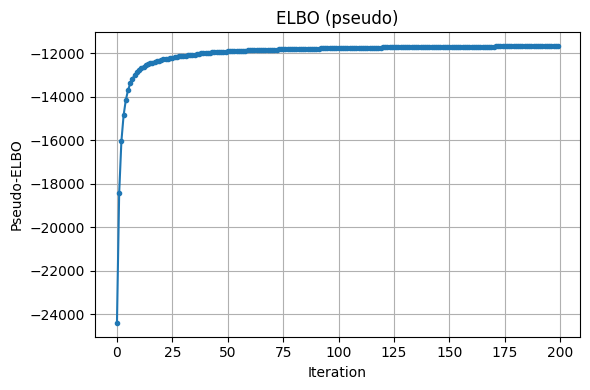

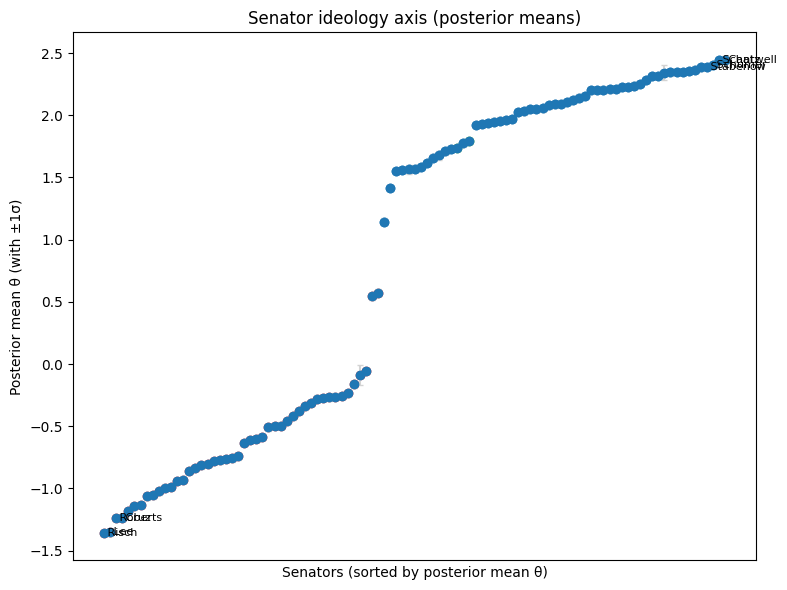

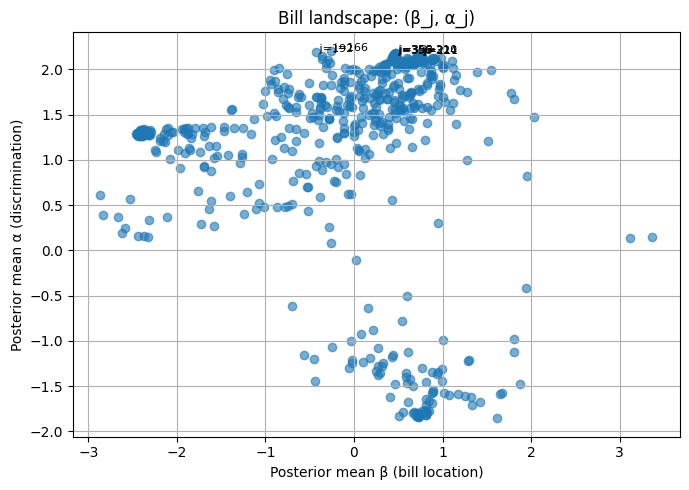

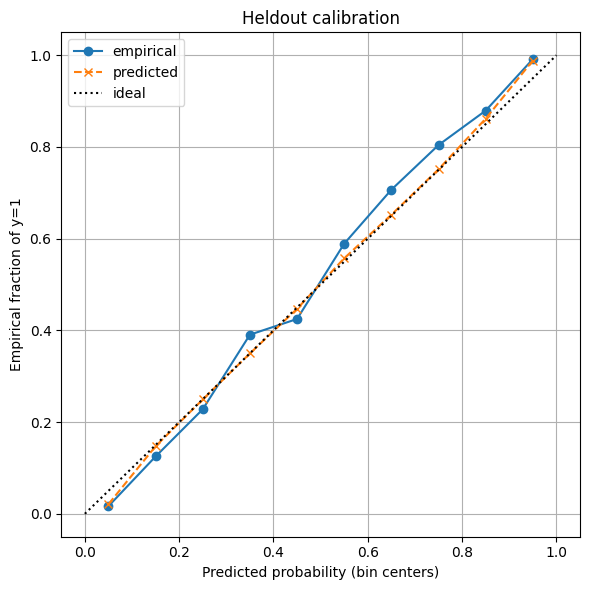

In [ ]:
# Example run (paste after defining the functions above)
res = run_cavi(
    votes=votes,
    senators=senators,
    parties=parties,
    states=states,
    heldout_frac=0.10,
    max_iters=200,
    tol=1e-5,
    priors=dict(
        mu_theta=0.0,
        sigma2_theta=1.0,
        mu_beta=0.0,
        sigma2_beta=1.0,
        mu_alpha=1.0,
        sigma2_alpha=1.0,
    ),
    init_scale=0.1,
    verbose=True,
    seed=123,
)

# plots:
plot_elbo(res["elbo_trace"])
plot_ideology_axis(
    res["m_theta"], res["V_theta"], res["parties"], res["senators"], highlight_n=4
)
plot_bill_landscape(res["m_beta"], res["m_alpha"], top_k=8)
plot_heldout_calibration(
    res["m_theta"], res["m_beta"], res["m_alpha"], res["heldout_pairs"], res["votes"]
)